In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import cProfile
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cross_validation import train_test_split
from __future__ import division


# Prepare Dataset with same covariance

In [34]:
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 10000000, 2
    np.random.seed(0)
    #C = np.array([[0., -0.23], [0.83, .23]])
    C = np.array([[0.,-0.23],[0.5,0.23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

# Get the data and plot

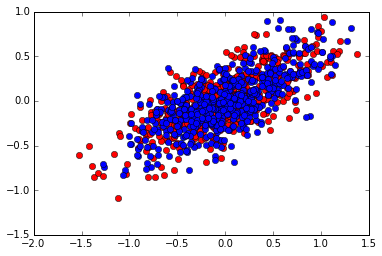

In [35]:
X,y = dataset_fixed_cov()
plt.figure()
plt.plot(X[0:500, 0], X[0:500, 1], 'o', color='red')
plt.plot(X[500:999, 0], X[500:999, 1], 'o', color='blue')


In [36]:
def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    print C
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

# prepare and normalize data,split

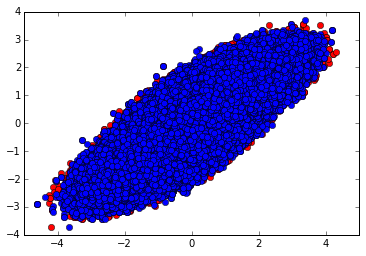

In [37]:
random_num = np.random.randint(X.shape[0], size = X.shape[0])
random_number = 11232015
rng = np.random.RandomState(random_number)
permutation1 = rng.permutation(len(random_num))
random_num = random_num[permutation1]
X = X[random_num]
y = y[random_num]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=11)
X_train = preprocessing.scale(X_train,axis = 0, with_mean=True, with_std=True)
X_test = preprocessing.scale(X_test,axis = 0, with_mean=True, with_std=True)
min_max_scaler = preprocessing.MinMaxScaler((-1,1))
y_train = min_max_scaler.fit_transform(y_train)
y_test = min_max_scaler.fit_transform(y_test)

plt.figure()
plt.plot(X_train[:, 0], X_train[:, 1], 'o', color='red')
plt.plot(X_test[:, 0], X_test[:, 1], 'o', color='blue')


# Add one to the column of train data

In [38]:
ones = np.ones((X_train.shape[0]))
ones = np.mat(ones).T
X_train = np.concatenate((X_train,ones),axis=1)
ones = np.ones((X_test.shape[0]))
ones = np.mat(ones).T
X_test = np.concatenate((X_test,ones),axis=1)

# Some functions

In [39]:

def get_huber_hinge(y,w,x,h):
    t = np.dot(w,np.transpose(x))
    y_t = y * t
    if(y_t > ( 1 + h)):
        return 0
    elif (y_t < ( 1 - h)):
        return (1 - y_t)
    else:
        return (( 1 + h - y_t) ** 2) / (4 * h)
    
def grad_huber_hinge(y,w,x,h):
    t = np.dot(w,np.transpose(x))  
    y_t = y * t
    if (y_t) > ( 1 + h):
        return 0
    elif y_t < ( 1- h):
        return -1 * (np.multiply(y,x))
    else:
        denominator = np.multiply(y,x) / (2 * h)
        denominator = np.multiply(-1,denominator)
        val = (1 + h - y_t)
        return np.multiply(val,denominator)
    

# Analytic Expressions

# #Objective with Huberized hinge-loss

In [40]:
def obj_huber_hinge(y,w,X_in,h):
    w_2 = np.power(np.linalg.norm(w),2)
    loss = np.zeros((X_in.shape[0]))
    for i in range(X_in.shape[0]):
        loss[i] = get_huber_hinge(y[i],w,X_in[i],h)
    tot_loss = np.sum((loss))    
    return (w_2 + ((1/X_in.shape[0]) * tot_loss))
    

# #gradient of huber-hinge-loss

In [41]:
def obj_grad_huber_hinge(y,w,X_in,h):
    w_2 = np.multiply(2,w)
    loss = np.zeros((X_in.shape[0],w.shape[1]))
    for i in range(X_in.shape[0]):
        loss[i] = grad_huber_hinge(y[i],w,X_in[i],h)
    tot_loss = np.sum((loss),axis = 0)
    tmp = 1 / X_in.shape[0]
    tot_loss = np.multiply(tmp,tot_loss)
    return np.add(w_2 , tot_loss)

# Compute_obj

In [42]:
def compute_obj(w,X_in,y,h):
    return obj_huber_hinge(y,w,X_in,h)

In [43]:
def compute_grad(w,X_in,y,h):
    return obj_grad_huber_hinge(y,w,X_in,h)

In [44]:
def update_theta(w,ita,grad):
    w = w - ita * grad
    return w 

# Grad_checker

In [45]:
def grad_checker(o_f, w):
    epsilon = 10**-4
    gradient = []
    for unit_vector in np.eye(w.shape[0], w.shape[0]):
        gradient1= (o_f(w+epsilon*unit_vector) - o_f(w-epsilon*unit_vector))/(2*epsilon)
        gradient.append(gradient1)
    return gradient

# Gradient Descent

In [46]:
def my_gradient_descent(y_in,X_in,y_test,X_test,ita,t):
    w = np.zeros((X_in.shape[1]))
    w = np.matrix(w)
    w_t = np.zeros((t))
    w_t_w = np.zeros((t,X_in.shape[1]))
    train_error = np.zeros((t))
    test_error = np.zeros((t))
    
    for i in range(t):
        w_t_w[i] = w
        w_t[i] = compute_obj(w,X_in,y_in,0.2)
        grad = compute_grad(w,X_in,y_in,0.2)
        w = update_theta(w,ita,grad)

        g_x_train = np.sign(np.dot(w,np.transpose(X_in)))
        error_train = np.multiply(y_in,g_x_train)
        wrong_mask_train = error_train <= 0
        tr_er_score =  np.sum(wrong_mask_train) / X_in.shape[0] 
        train_error[i] = tr_er_score 
        
        g_x_test = np.sign(np.dot(w,np.transpose(X_test)))
        error_test = np.multiply(y_test,g_x_test)
        wrong_mask_test = error_test <= 0
        tt_er_score =  np.sum(wrong_mask_test) / X_test.shape[0] 
        test_error[i] = tt_er_score 
    
    plt.plot(np.arange(w_t.shape[0]),w_t,'r',linewidth=2.5, linestyle="-",label = 'Obective function')
    plt.xlabel("Iterations")
    plt.ylabel("Objective function")
    plt.title("Gradient Descent")
    plt.legend(loc='upper right')
    plt.show()
    
    
    
    plt.plot(np.arange(train_error.shape[0]),train_error,'c',linewidth=2.5, linestyle="-",label = 'train error')
    plt.plot(np.arange(test_error.shape[0]),test_error,'g',linewidth=2.5, linestyle="-",label = 'test error')

    plt.xlabel("Iterations")
    plt.ylabel("% Misclassification Error")
    plt.title("Gradient Descent")
    plt.legend(loc='upper right')
    plt.show()
    
    
    
    
    index = np.argmin(w_t)
    print index
    print w_t[index]
    return w_t_w[index]
    

# My_SVM

In [47]:
def my_svm(X_in,y_in,X_test,y_test):
    max_iter = 1
    ita = 0.1 * (1.1 ** 10)
    w = my_gradient_descent(y_in,X_in,y_test,X_test,ita,max_iter)  
    print w

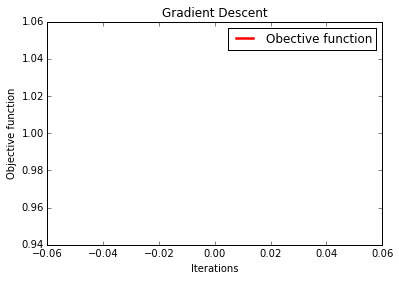

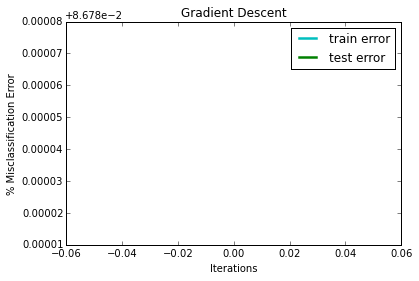

0
1.0
[ 0.  0.  0.]
--- 529.843847036 seconds for my_svm---


In [48]:
start_time = time.time()
my_svm(X_train,y_train,X_test,y_test)
print("--- %s seconds for my_svm---" % (time.time() - start_time))

(500, 3)
(500, 1)
[[-1.56105686 -0.68966361  1.          1.        ]
 [ 0.47679761  0.0673433   1.          1.        ]
 [-0.74202249 -0.23785172  1.          1.        ]
 ..., 
 [ 1.3965502   1.71082903  1.          1.        ]
 [ 1.61006469  1.11429946  1.          1.        ]
 [ 1.82126915  1.4153125   1.          1.        ]]


In [56]:
def my_svm2(X_in):
    print 'svm2'
    

In [57]:
def compute_obj(w,X_train,y_train):
    
    
    print 'f_w'
    
    return f_w
    

In [58]:
def compute_grad():
    print compute_grad
    

In [59]:
def my_gradient_descent(ita, maxiter):
    w = np.zeros((1))
    
    